## Initial Setup

In [24]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import matplotlib.pyplot as plt

%matplotlib inline


## User input

In [25]:
# Kasen (2017) models directory name:
kasen_dirname='/data/des40.a/data/dtucker/DESGW_analysis/Kasen_Kilonova_Models_2017/kilonova_models'


# Redshift and 1sigma error in redshift based on LIGO luminosity distance, 1sigma error in luminosity distance...
z = 0.059
sigma_z = 0.011  # not currently used..


#inputFile_obs_list = ['2019noq.flm', 
#                      'AT2019npw-3.flm', 
#                      'AT2019ntp.flm', 
#                      'AT2019num.flm', 
#                      '2019ntn.flm', 
#                      'AT2019ntr.flm', 
#                      'AT2019omx.flm' ]

# Time [in days] past the merger event when the spectrum was observed...
#t_dict = {'2019noq.flm': 6., 
#          'AT2019npw-3.flm': 12., 
#          'AT2019ntp.flm': 17., 
#          'AT2019num.flm': 12., 
#          '2019ntn.flm': 6., 
#          'AT2019ntr.flm': 14., 
#          'AT2019omx.flm': 14.} 


inputFile_obs_list = ['2019noq.flm', 
                      'AT2019npw-3.flm', 
                      'AT2019ntp.flm', 
                      'AT2019num.flm', 
                      'desgw-190814c.flm', 
                      '2019ntn.flm', 
                      'AT2019ntr.flm', 
                      'AT2019omx.flm', 
                      'desgw-190814d.flm']
#                      'AT2019nte.flm', 

# Time [in days] past the merger event when the spectrum was observed...
t_dict = {'2019noq.flm': 6.49, 
          'AT2019npw-3.flm': 12.45, 
          'AT2019ntp.flm': 17.41, 
          'AT2019num.flm': 12.45, 
          'desgw-190814c.flm': 2.44, 
          '2019ntn.flm': 6.49, 
          'AT2019ntr.flm': 14.45, 
          'AT2019omx.flm': 14.45, 
          'desgw-190814d.flm': 2.44}
#          'AT2019nte.flm': ???, 



## Fitting function to Kasen (2017) models

In [26]:
def fit_to_kasen(kasen_dirname, wavelength_array, df_obs_new, t, z):

    names = glob.glob(kasen_dirname+'/knova_*.h5')

    bestSum2 = 9.999e+99
    bestName = ''
    c = 2.99e10   # speed of light in cm/sec...
    
    # Loop over all models at redshift z...
    for name in names:
        
        # open model file
        fin    = h5py.File(name,'r')

        # frequency in Hz
        nu    = np.array(fin['nu'],dtype='d')
        # array of time in seconds
        times = np.array(fin['time'])
        # covert time to days
        times = times/3600.0/24.0

        # specific luminosity (ergs/s/Hz)
        # this is a 2D array, Lnu[times][nu]
        Lnu_all   = np.array(fin['Lnu'],dtype='d')

        # index corresponding to t
        it = bisect.bisect(times,t)
        # spectrum at this epoch
        Lnu = Lnu_all[it,:]

        # if you want thing in Flambda (ergs/s/Angstrom)
        lam0  = c/nu*1e8
        lam   = lam0*(1+z)
        Llam = Lnu*nu**2.0/c/1e8

        df_model = pd.DataFrame({'LAMBDA0':lam0, 'LAMBDA':lam, 'Llam':Llam})

        spec_flux_model = interpolate.interp1d(df_model.LAMBDA, df_model.Llam,bounds_error=False, fill_value=0.,kind='linear')
        spec_flux_model_array = spec_flux_model(wavelength_array)

        df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

        norm = df_model_new['Llam'].median()

        df_model_new['normLlam'] = df_model_new['Llam']/norm

        merged = pd.merge(df_obs_new, df_model_new, on='LAMBDA')
        
        merged['delta_flux'] = merged['normFLUX'] - merged['normLlam']

        mask = ((merged.normFLUX.isnull()) | (merged.normLlam.isnull()))
        mask = (mask == False)
        
        if np.any(mask):

            
            sum2 = np.sum(np.square(merged[mask].delta_flux)) / np.sum(mask)

            if sum2 < bestSum2:
                bestSum2 = sum2
                bestName = name

       
    return bestName, sum2

## Plot function

In [27]:
def plot_obs_and_bestfit_model(obsname, kasen_dirname, name, wavelength_array, df_obs_new, t, z, sum2):

    c = 2.99e10   # speed of light in cm/sec...

    basename = name
    name = kasen_dirname+'/'+basename

    fin    = h5py.File(name,'r')

    # frequency in Hz
    nu    = np.array(fin['nu'],dtype='d')
    # array of time in seconds
    times = np.array(fin['time'])
    # covert time to days
    times = times/3600.0/24.0

    # specific luminosity (ergs/s/Hz)
    # this is a 2D array, Lnu[times][nu]
    Lnu_all   = np.array(fin['Lnu'],dtype='d')

    # index corresponding to t
    it = bisect.bisect(times,t)
    # spectrum at this epoch
    Lnu = Lnu_all[it,:]

    # if you want thing in Flambda (ergs/s/Angstrom)
    lam0  = c/nu*1e8
    lam   = lam0*(1+z)
    Llam = Lnu*nu**2.0/c/1e8

    df_model = pd.DataFrame({'LAMBDA0':lam0, 'LAMBDA':lam, 'Llam':Llam})

    spec_flux_model = interpolate.interp1d(df_model.LAMBDA, df_model.Llam,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_model_array = spec_flux_model(wavelength_array)

    df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

    norm = df_model_new['Llam'].median()

    df_model_new['normLlam'] = df_model_new['Llam']/norm

    ax = df_model_new.plot('LAMBDA','normLlam',grid=True)
    df_obs_new.plot('LAMBDA', 'normFLUX', ax=ax)
    title = """%s: %s (mean sum2=%.2f)""" % (obsname, basename, sum2)
    plt.title(title)

    return 0


## Fit each input observed spectrum

2019noq.flm knova_d1_n10_m0.030_vk0.30_fd0.1_Xlan1e-5.0.h5 0.306095627116
AT2019npw-3.flm knova_d1_n10_m0.030_vk0.20_Xlan1e-9.0.h5 1.59275184569
AT2019ntp.flm knova_d1_n10_m0.030_vk0.10_Xlan1e-4.0.h5 331.231080409
AT2019num.flm knova_d1_n10_m0.030_vk0.20_Xlan1e-9.0.h5 1.87657994604
desgw-190814c.flm knova_d1_n10_m0.030_vk0.03_Xlan1e-4.0.h5 0.999118480483
2019ntn.flm knova_d1_n10_m0.025_vk0.30_Xlan1e-4.5.h5 0.122755659855
AT2019ntr.flm knova_d1_n10_m0.030_vk0.20_Xlan1e-5.0.h5 1.09320613015
AT2019omx.flm knova_d1_n10_m0.030_vk0.20_Xlan1e-4.5.h5 0.848422946456
desgw-190814d.flm knova_d1_n10_m0.030_vk0.30_Xlan1e-4.0_vs0.75.h5 0.190789497298


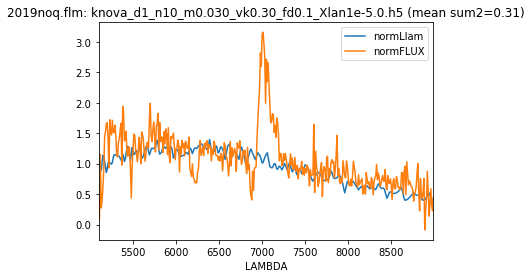

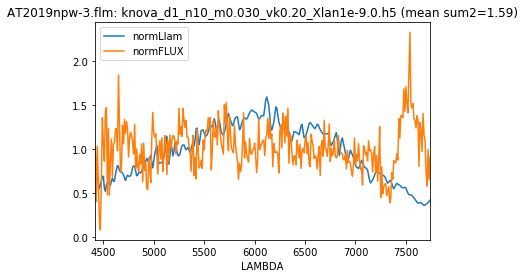

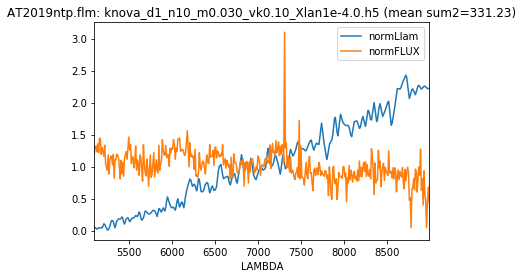

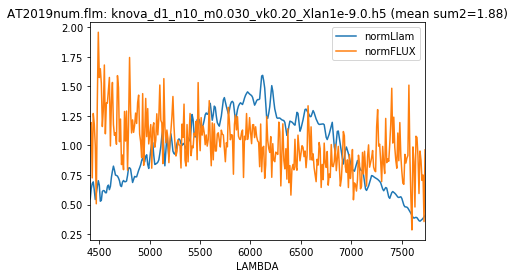

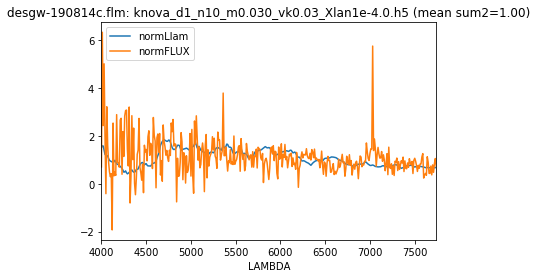

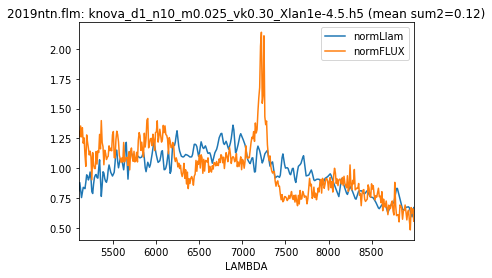

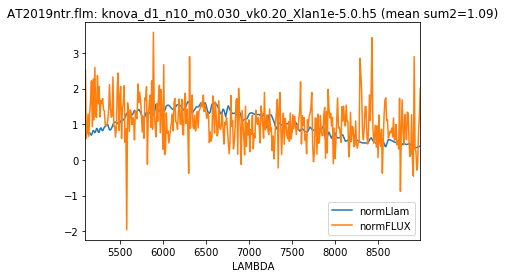

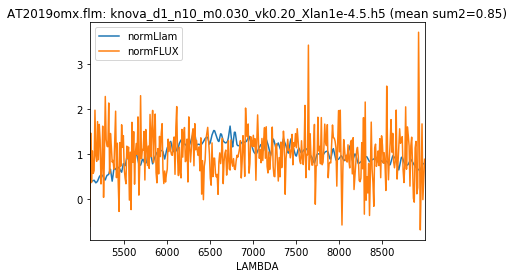

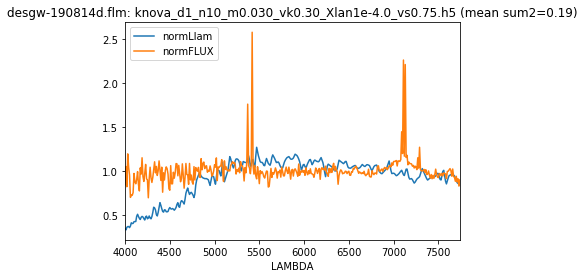

In [28]:
for inputFile_obs in inputFile_obs_list:
    
    t = t_dict[inputFile_obs]

    obsname = os.path.basename(inputFile_obs)
    print obsname, 
    
    df_obs = pd.read_csv(inputFile_obs, sep='\s+', header = None, names = ['LAMBDA', 'FLUX'])
    
    lambda_lo = df_obs.LAMBDA.min()
    lambda_hi = df_obs.LAMBDA.max()

    wavelength_array = np.arange(lambda_lo, lambda_hi, 10.)

    spec_flux_obs = interpolate.interp1d(df_obs.LAMBDA, df_obs.FLUX,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_obs_array = spec_flux_obs(wavelength_array)

    df_obs_new = pd.DataFrame({'LAMBDA':wavelength_array, 'FLUX':spec_flux_obs_array})

    norm = df_obs_new['FLUX'].median()
    df_obs['normFLUX'] = df_obs['FLUX']/norm
    df_obs_new['normFLUX'] = df_obs_new['FLUX']/norm

    name, sum2 = fit_to_kasen(kasen_dirname, wavelength_array, df_obs_new, t, z)
    
    name = os.path.basename(name)
    
    print name, sum2
    
    status = plot_obs_and_bestfit_model(obsname, kasen_dirname, name, wavelength_array, df_obs_new, t, z, sum2)
    
    